# ***ODE Parameter Estimation with Competition Model***
---

In [2]:
using LGCPGradientMatching
using Plots
using Random
using Serialization

[ Info: Precompiling LGCPGradientMatching [0fd7f208-fc42-40fc-857a-d2b7a083df23]


## ***1. Simulate event data***

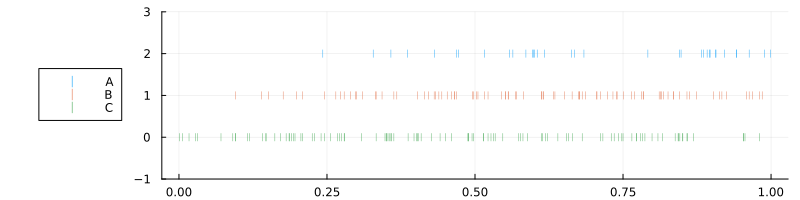

In [3]:
seed = 1
λ0 = 50.
dat = sim_Competition_event_data(seed=seed, λ0=λ0);

# plot simulated data
plot(size=(800,200), legend=:outerleft)
scatter!(dat.times[1], zeros(length(dat.times[1])) .+ 2, m=:vline, label="A")
scatter!(dat.times[2], zeros(length(dat.times[2])) .+ 1, m=:vline, label="B")
scatter!(dat.times[3], zeros(length(dat.times[3])), m=:vline, label="C")
ylims!(-1,3)

## ***2. Define models***

In [4]:
times = Dict(1=>dat.times[1], 2=>dat.times[2], 3=>dat.times[3])
classes = Dict(1=>"A", 2=>"B", 3=>"C")
U = 21  # number of inducing points
T = 100  # number of observation points
T_coarse = 20  # number of observation points for coarsly discretized GPGM
base_kernel = :RBF
ϕ = [5.0, 0.15, 0.1]
γ = 0.1

# ODE guided Cox process with LGCP-based Gradient Matching
odecox = CompetitionCoxProcess(
    times, classes; λ0=λ0, U=U, T=T, γ=γ,
    base_kernel=base_kernel, ascale=ϕ[1], lscale=ϕ[2], δ=ϕ[3])
# Conventional ODE Model with GP-based Gradient Matching (coarsly discretized observation points)
odemod_coarse = CompetitionModel(
    times, classes; λ0=λ0, U=U, T=T_coarse, γ=γ,
    base_kernel=base_kernel)  # NOTE: kernel parameters and σ are optimized
# Conventional ODE Model with GP-based Gradient Matching (finely discretized observation points)
odemod_fine = CompetitionModel(
    times, classes; λ0=λ0, U=U, T=T, γ=γ,
    base_kernel=base_kernel);  # NOTE: kernel parameters and σ are optimized

## ***3. Inference***
MCMC iteration settings

In [5]:
n_burnin = 10000
n_thinning = 20
n_samples = 1000
n_total_iter = n_burnin + n_thinning * n_samples;

Execute inference

In [6]:
Random.seed!(seed)
chain_odecox = Chain(
    odecox, n_burnin=n_burnin, n_thinning=n_thinning,
    blocks=[HMCBlock(:y, L=10), HMCBlock(:x, L=10), HMCBlock(:θ, L=10)])
chain_odecox = train!(odecox, n_total_iter, chain_odecox)

chain_coarse = Chain(
    odemod_coarse, n_burnin=n_burnin, n_thinning=n_thinning,
    blocks=[HMCBlock(:x, L=10), HMCBlock(:θ, L=10)])
chain_coarse = train!(odemod_coarse, n_total_iter, chain_coarse)

chain_fine = Chain(
    odemod_fine, n_burnin=n_burnin, n_thinning=n_thinning,
    blocks=[HMCBlock(:x, L=10), HMCBlock(:θ, L=10)])
chain_fine = train!(odemod_fine, n_total_iter, chain_fine);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|███████████████████████████| Time: 0:12:25 (24.84 ms/it)
  iter:                             30000
  total_iter:                       30000
  ll:                               -616.630
  ll_y⎸zσϕ:                         -601.339 (-2.004/variable)
  ll_z⎸ϕ:                           28.166 (9.389/category)
  ll_grad:                          -11.982
  lp_θ:                             -31.475

  sample blocks:                    
                                    x - HMC
                                    θ - HMC
  accept % (in recent 100 trials):  
                             

## ***4. Store results***

In [7]:
results =  Dict(
    λ0 => Dict(
        "data" => dat,
        "odecox" => (mod=odecox, chain=chain_odecox),
        "odemod_coarse" => (mod=odemod_coarse, chain=chain_coarse),
        "odemod_fine" => (mod=odemod_fine, chain=chain_fine)
    )
);

## ***5. Experiments with different $\lambda_0$***

In [8]:
Random.seed!(seed)
for λ0 in [100., 1000.]
    # simulate data
    dat = sim_Competition_event_data(seed=seed, λ0=λ0);

    # define models
    times = Dict(1=>dat.times[1], 2=>dat.times[2], 3=>dat.times[3])
    classes = Dict(1=>"A", 2=>"B", 3=>"C")

    odecox = CompetitionCoxProcess(
        times, classes; λ0=λ0, U=U, T=T, γ=γ,
        base_kernel=base_kernel, ascale=ϕ[1], lscale=ϕ[2], δ=ϕ[3])
    odemod_coarse = CompetitionModel(
        times, classes; λ0=λ0, U=U, T=T_coarse, γ=γ,
        base_kernel=base_kernel)
    odemod_fine = CompetitionModel(
        times, classes; λ0=λ0, U=U, T=T, γ=γ,
        base_kernel=base_kernel)

    # inference
    chain_odecox = Chain(
        odecox, n_burnin=n_burnin, n_thinning=n_thinning,
        blocks=[HMCBlock(:y, L=10), HMCBlock(:x, L=10), HMCBlock(:θ, L=10)])
    chain_odecox = train!(odecox, n_total_iter, chain_odecox)

    chain_coarse = Chain(
        odemod_coarse, n_burnin=n_burnin, n_thinning=n_thinning,
        blocks=[HMCBlock(:x, L=10), HMCBlock(:θ, L=10)])
    chain_coarse = train!(odemod_coarse, n_total_iter, chain_coarse)

    chain_fine = Chain(
        odemod_fine, n_burnin=n_burnin, n_thinning=n_thinning,
        blocks=[HMCBlock(:x, L=10), HMCBlock(:θ, L=10)])
    chain_fine = train!(odemod_fine, n_total_iter, chain_fine)

    # Store results
    results[λ0] = Dict(
        "data" => dat,
        "odecox" => (mod=odecox, chain=chain_odecox),
        "odemod_coarse" => (mod=odemod_coarse, chain=chain_coarse),
        "odemod_fine" => (mod=odemod_fine, chain=chain_fine)
    );
end;

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|███████████████████████████| Time: 0:04:28 ( 8.95 ms/it)
  iter:                             30000
  total_iter:                       30000
  ll:                               -144.233
  ll_y⎸zσϕ:                         -145.210 (-0.484/variable)
  ll_z⎸ϕ:                           30.517 (10.172/category)
  ll_grad:                          0.790
  lp_θ:                             -30.329

  sample blocks:                    
                                    x - HMC
                                    θ - HMC
  accept % (in recent 100 trials):  
                              

## ***6. Save results***

In [9]:
_dir = @__DIR__
if ~Base.isdir("$(_dir)/../results")
    Base.mkdir("$(_dir)/../results")
end
open("$(_dir)/../results/exp-5.2.2-Competition_seed$(seed).dat", "w") do io
    Serialization.serialize(io, results)
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*